In [111]:
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
from nltk.tokenize                    import word_tokenize
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing            import normalize
from sklearn import cluster
from sklearn.cluster                  import KMeans
from wordcloud                        import WordCloud
from unidecode                        import unidecode
import matplotlib.pyplot  as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score,confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import f1_score

In [112]:
pip install unidecode

In [113]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [114]:
df_pos = pd.read_csv('rt-polarity.pos', delimiter=' . \n', encoding='latin-1', header=None, engine='python')
df_pos.shape

(5331, 1)

In [115]:
df_neg = pd.read_csv('rt-polarity.neg', delimiter=' . \n', encoding='latin-1', header=None, engine='python')
df_neg.shape

(5331, 1)

In [116]:
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

def processCorpus(corpus, language):
    stopwords = nltk.corpus.stopwords.words(language)
    processed_corpus = []

    for document in corpus:
        document = document.replace(',', '')
        document = document.replace('-', ' ')
        document = document.rstrip('\n')
        document = document.casefold()
        listOfTokens = word_tokenize(document)
        listOfTokens = removeWords(listOfTokens, stopwords)
        document = " ".join(listOfTokens)
        document = unidecode(document)

        processed_corpus.append(document)

    return processed_corpus

In [117]:
language = 'english'
pos = processCorpus(df_pos[0], language)
pos = pd.DataFrame(pos)
pos.head()

,0
0,rock destined 21st century 's new `` conan `` ...
1,gorgeously elaborate continuation `` lord ring...
2,effective tepid biopic
3,sometimes like go movies fun wasabi good place...
4,emerges something rare issue movie 's honest k...


In [118]:
neg = processCorpus(df_neg[0], language)
neg = pd.DataFrame(neg)
neg.head()

,0
0,simplistic silly tedious .
1,'s laddish juvenile teenage boys could possibl...
2,exploitative largely devoid depth sophisticati...
3,[ garbus ] discards potential pathological stu...
4,visually flashy narratively opaque emotionally...


In [119]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(pos[0])
tfidf_pos = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())
print("{} rows".format(tfidf_pos.shape[0]))
print("{} columns".format(tfidf_pos.shape[1]))

5331 rows
12415 columns


In [120]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(neg[0])
tfidf_neg = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names_out())
print("{} rows".format(tfidf_neg.shape[0]))
print("{} columns".format(tfidf_neg.shape[1]))

5331 rows
12775 columns


In [121]:
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending = False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update( {a[i,0] : a[i,1]} )
    return centroid_dict

def generateWordClouds(centroids, cluster):
    wordcloud = WordCloud(max_font_size=100, background_color = 'white')
    centroid_dict = centroidsDict(centroids, cluster)
    wordcloud.generate_from_frequencies(centroid_dict)

    plt.figure()
    plt.title('Cluster {}'.format(cluster))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [122]:
kmeans_text = KMeans(n_clusters=2)
kmeans_pos = kmeans_text.fit(tfidf_pos)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


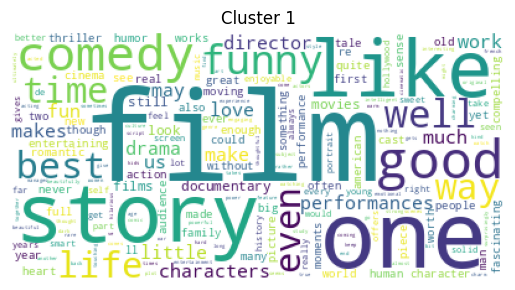

In [123]:
centroids = pd.DataFrame(kmeans_pos.cluster_centers_)
centroids.columns = tfidf_pos.columns
generateWordClouds(centroids, 1)

In [124]:
kmeans_text = KMeans(n_clusters=2)
kmeans_neg = kmeans_text.fit(tfidf_neg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


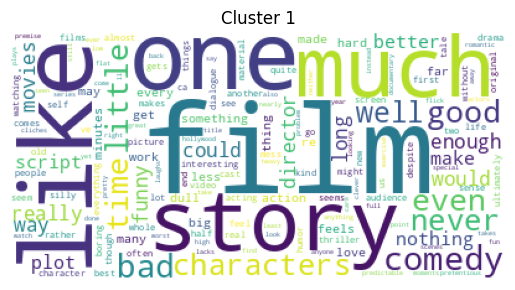

In [125]:
centroids = pd.DataFrame(kmeans_neg.cluster_centers_)
centroids.columns = tfidf_neg.columns
generateWordClouds(centroids, 1)

In [126]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

nb_model = MultinomialNB()
knn_model = KNeighborsClassifier()
svm_model = SVC()

nb_pipeline = make_pipeline(TfidfVectorizer(), nb_model)
knn_pipeline = make_pipeline(TfidfVectorizer(), knn_model)
svm_pipeline = make_pipeline(TfidfVectorizer(), svm_model)

In [127]:
pos['Sentiment'] = 1
neg['Sentiment'] = 0
df = pd.concat([pos, neg], ignore_index=True)
df.head()

,0,Sentiment
0,rock destined 21st century 's new `` conan `` ...,1
1,gorgeously elaborate continuation `` lord ring...,1
2,effective tepid biopic,1
3,sometimes like go movies fun wasabi good place...,1
4,emerges something rare issue movie 's honest k...,1


In [128]:
corpus = df[0].values.tolist()
y = df['Sentiment'].values.tolist()

In [129]:
f1_scores = []

for train_index, test_index in kf.split(corpus, y):
    X_train, X_test = np.array(corpus)[train_index], np.array(corpus)[test_index]
    y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]

    nb_pipeline.fit(X_train, y_train)
    nb_pred = nb_pipeline.predict(X_test)
    nb_f1 = f1_score(y_test, nb_pred, average='weighted')
    print(f'F1 - Naive Bayes: {nb_f1}')
    f1_scores.append(nb_f1)

    knn_pipeline.fit(X_train, y_train)
    knn_pred = knn_pipeline.predict(X_test)
    knn_f1 = f1_score(y_test, knn_pred, average='weighted')
    print(f'F1 - kNN: {knn_f1}')
    f1_scores.append(knn_f1)

    svm_pipeline.fit(X_train, y_train)
    svm_pred = svm_pipeline.predict(X_test)
    svm_f1 = f1_score(y_test, svm_pred, average='weighted')
    print(f'F1 - SVM: {svm_f1}')
    f1_scores.append(svm_f1)

F1 - Naive Bayes: 0.7693033633727492
F1 - kNN: 0.693846168349349
F1 - SVM: 0.754325275450201
F1 - Naive Bayes: 0.7683819675400282
F1 - kNN: 0.6919647067513595
F1 - SVM: 0.7533950659945391
F1 - Naive Bayes: 0.7753140445773338
F1 - kNN: 0.6983998787330241
F1 - SVM: 0.7649716867688591
F1 - Naive Bayes: 0.7691720646757629
F1 - kNN: 0.711934243314875
F1 - SVM: 0.7626639562460675
F1 - Naive Bayes: 0.7747451090880276
F1 - kNN: 0.6969458526968032
F1 - SVM: 0.7650068476198333


In [130]:
modelos = ['F1 - Naive Bayes', 'F1 - kNN', 'F1 - SVM']
for i, model in enumerate(modelos):
    x = [f1_scores[j] for j in range(i, len(f1_scores), 3)]
    mean_f1 = np.mean(x)
    print(f'Média do {model}: {mean_f1}')

Média do F1 - Naive Bayes: 0.7713833098507804
Média do F1 - kNN: 0.6986181699690823
Média do F1 - SVM: 0.7600725664159


In [131]:
X_train, X_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier()
knn_pipeline = make_pipeline(CountVectorizer(), knn_model)
knn_pipeline.fit(X_train, y_train)

y_pred = knn_pipeline.predict(X_test)

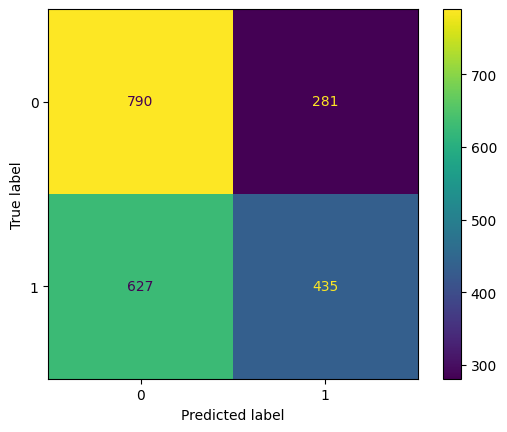

In [132]:
cm = confusion_matrix(y_test, y_pred, labels=knn_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_model.classes_)
disp.plot()
plt.show()

In [133]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, pos_label=1)
recall = metrics.recall_score(y_test, y_pred, pos_label=1)
f1_weighted = metrics.f1_score(y_test, y_pred, average='weighted', pos_label=1)
f1 = (2 * precision * recall) / (precision + recall)

print('Acurácia:', accuracy)
print('Precisão:', precision)
print('Revocação:', recall)
print('F1:', f1)

Acurácia: 0.5743084857008908
Precisão: 0.6075418994413407
Revocação: 0.4096045197740113
F1: 0.48931383577052867
